In [1]:
## Import needed mods
import numpy as np, pandas as pd, os, glob, seaborn as sns
import vcfpy as vcf, hypermutatorqtl as hqtl
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
## Set paths to phenotype data
pheno_path = '../PHENOTYPE/F1-progeny-info-processed.csv.gz'

## Set path to chromosome length dataframe
chrlen_path = '../DATA/Clens.csv.gz'

## Set paths to genotype dataframes
gt_path = '../GENOTYPE/Bt65xH99_F1_progeny-SNPS.csv.gz'

## Set MAT locus
MAT = hqtl.MAT

## Set parental lables
h99_label = hqtl.h99_label
bt_label =  hqtl.bt_label

## Set kb conversion factor
kb = 1000

## Bring in centromere paths
Centromeres = hqtl.Centromeres

## Load in phenotype data
data = pd.read_csv(pheno_path,index_col=0)

## View head
data.head().T

,30,35,47,10,5
F1 Progeny #,30,35,47,10,5
Mutation rate (qualitative),---,---,---,---,---
Mutation rate (quantitative),0,3.09632e-09,3.37894e-09,5.80508e-09,6.6136e-09
Upper confidence interval,0,2.6642e-10,2.5863e-10,9.7708e-10,1.7808e-09
Lower confidence interval,0,7.93921e-09,8.79736e-09,1.32958e-08,1.34964e-08
Transposition frequency,0,0,100,0,20
Rate,0,0.0309632,0.0337894,0.0580508,0.066136
Uci,0,0.0026642,0.0025863,0.0097708,0.017808
Lci,0,0.0793921,0.0879736,0.132958,0.134964


In [3]:
## Load in genotype data
## Genotypes per site
SNP = pd.read_csv(gt_path,index_col=0)

## Gather columns from dataframe
cols = SNP.columns.tolist()

## Gather samples
samples = cols[:cols.index('Pos')]

## Check work
assert len(samples) == 28, "Missing samples"

## Gather contig names
chrlist = sorted(SNP.Contig.unique())

## Check work
assert len(chrlist) >= 14, "Missing chromosomes in genotype data."

## show shape of df, print a few chromosomes, and print some samples
SNP.shape, chrlist[:3], samples[:3]

((215411, 38), ['Chr_1', 'Chr_10', 'Chr_11'], ['41', '17', '36'])

In [4]:
## Calculate the inter marker interval
imi = np.concatenate([np.abs(np.diff(a[1].Pos)) 
                      for a in SNP.groupby('Contig')])

## take imi < 2 kb
imi_2000 = [i for i in imi if i<2*kb]

## print median imi and percent < 2kb
np.median(imi), len(imi_2000)/len(imi)

(45.0, 0.999470744717893)

In [5]:
## Convert SNP data to float
## Set columns not to be converted
col_not_flot = ['Contig','Alt','Ref','Type']

## Convert each column in SNP
for c in SNP.columns:
    if c not in col_not_flot:
        SNP[c] = SNP[c].apply(float)

## Add parental data
## Set SNP data
SNP['Bt65'] = 1.
SNP['crg1'] = 0.
        
## View head
SNP.head()

,41,17,36,14,12,29,34,26,13,18,...,DPmin,Alt,Ref,Type,Altlen,Qual,NALT,AF,Bt65,crg1
191,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,11.0,C.T,C,SNV,1.0,4.526492,1.0,0.464286,1.0,0.0
192,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,12.0,C.T,C,SNV,1.0,4.516699,1.0,0.428571,1.0,0.0
339,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,73.0,C.G,C,SNV,1.0,4.731814,1.0,0.500000,1.0,0.0
341,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,85.0,A.T,A,SNV,1.0,4.592010,1.0,0.428571,1.0,0.0
377,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,80.0,A.G,A,SNV,1.0,4.520617,1.0,0.214286,1.0,0.0


In [6]:
clens = pd.read_csv('../DATA//H99_chrommap.csv.gz')
clens.tail()

,Seqid,Length,Contig,Chrom,Cumsum,Midpts,Nsnps
10,CP003830.1,1561994,Chr_11,11,14855526,15636523.0,18069
11,CP003831.1,774062,Chr_12,12,16417520,16804551.0,9015
12,CP003832.1,756744,Chr_13,13,17191582,17569954.0,8509
13,CP003833.2,942867,Chr_14,14,17948326,18419759.5,11172
14,CP003834.1,24919,M,M,18891193,18903652.5,0


In [7]:
clens = clens[(clens.Chrom!='M')]

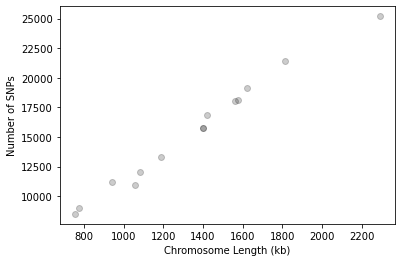

In [8]:
## Plot the number of SNPs as a ftn of chromosome size
plt.plot(clens.Length.values/kb,clens.Nsnps,'ko',alpha=.2);

## Set y and x-lables
plt.ylabel('Number of SNPs')
plt.xlabel('Chromosome Length (kb)');

In [9]:
## Append parental sample names
if 'Bt65' not in samples:
    samples.append('Bt65')
    samples.append('crg1')
    
## Drop baddies
segs_to_use = [str(s) for s in samples 
               if s not in ['12','14','25','41']]

## print number of segregants
len(segs_to_use)

26

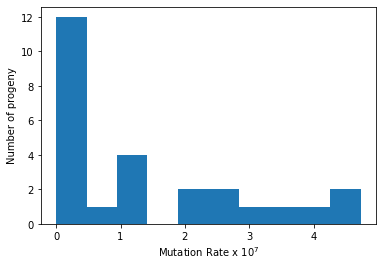

In [10]:
## Gather phenotype data
to_use_data = data.T[segs_to_use].T[['F1 Progeny #','Rate']].copy()#*(10**9)
to_use_data.index =[ str(s) for s in  to_use_data.index]
to_use_data['Rate']=to_use_data['Rate'].apply(float)

## plot histogram of phenotype
plt.hist(to_use_data['Rate'].values);

## add x and ylabel
plt.xlabel('Mutation Rate x 10$^7$')
plt.ylabel('Number of progeny');

In [11]:
import scipy.stats as ss

In [12]:
ss.shapiro(to_use_data.Rate.values)

ShapiroResult(statistic=0.8219845294952393, pvalue=0.00042662565829232335)

In [13]:
## Gather segregants
segs = [s for s in samples if s not in ['Bt65','crg1']]
len(segs)

28

11 12 0.9131366682533448
12 11 0.9131366682533448
23 41 0.7645917173266635
41 23 0.7645917173266635


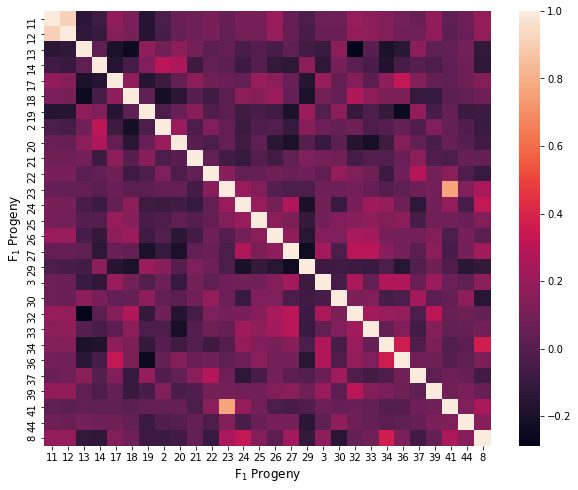

In [14]:
## Plot correlation of genoytpes
## among progeny, identfying clones

## Calculate correlations
corrdf = SNP[sorted(segs)].drop_duplicates().corr()

## Call figure
fig,ax = plt.subplots(1,1,figsize=(10,8))
sns.heatmap(corrdf);
plt.ylabel('F$_1$ Progeny',fontsize=12)
plt.xlabel('F$_1$ Progeny',fontsize=12);

## print clone corrilation
for s in corrdf.columns:
    for j in corrdf.columns:
        if s != j and corrdf[s][j] > .5:
            print(s,j,corrdf[s][j])

In [15]:
## Check work
assert 'Bt65' in SNP.columns
assert 'crg1' in SNP.columns
assert 'crg1' in segs_to_use
assert 'Bt65' in segs_to_use

In [16]:
## Conduct QTL mapping
## Gather unique loci
test = SNP[segs_to_use].drop_duplicates()

## Check work
assert test.shape[0] <= SNP.shape[0]

## Cunduct QTL mapping
test['Pval'] = test.apply(hqtl.crypto_kruskal,
                args=[to_use_data.T[segs_to_use].T['Rate']],
                axis=1)

## Merge resutls and save
pvaldf = SNP.merge(test)

In [17]:
## Set colors
chrom_colors = hqtl.colors

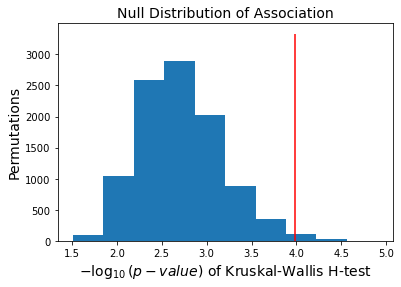

In [18]:
## Conduct permutation tests
## Initilize list
perms = []

## Set number of permutations and save path
kps = 10000
permpath = '../DATA/H99_Hyper_perms.csv.gz'

## Load if they exist
if os.path.exists(permpath):
    perms = pd.read_csv(permpath,index_col=0).T.values[0]

else:
    
    ## Condduct permutations
    ## Gather loci for tests
    test = SNP[segs_to_use].drop_duplicates()
    
    ## Rerun till kps is reached
    while len(perms) < kps:
    
        ## permute segregants
        ran_segs = np.random.permutation(segs_to_use)
        
        ## Cunduct QTL mapping
        test['Pval'] = test[segs_to_use].apply(crypto_kruskal,
                   args=[to_use_data.T[ran_segs].T['Rate'].values],
                   axis=1)
        
        ## Append genome wide max
        perms.append(test.Pval.max())
    
    ## Save perm datarame
    pd.DataFrame(perms).to_csv(permpath)
    
## Gather thresholds and print
thres_95 = np.round(np.percentile(perms,95),2)
thres_99 = np.round(np.percentile(perms,99),2)

## plot null distirbution of association
## plot histogram
plt.hist(perms);

## Add 99 threhsold
plt.vlines(thres_99,0,int(len(perms)/3),color='r');

## Add lables
plt.title('Null Distribution of Association',fontsize=14)
plt.ylabel('Permutations',fontsize=14);
plt.xlabel('$-\log_{10}\,(p-value)$ of Kruskal-Wallis H-test',
           fontsize=14);

In [19]:
## Gather maximum, right chromosome positon 
posmax = clens.Cumsum.tolist()[-1] + clens.Length.tolist()[-1]

In [20]:
## Slice pvalue dataframe on QTL chormosomes
chr3_ix = pvaldf[(pvaldf.Contig=='Chr_3')].Pval.idxmax()
chr3_gt = pvaldf.T[chr3_ix]
to_use_data['CH3'] = chr3_gt


chr11_ix = pvaldf[(pvaldf.Contig=='Chr_11')].Pval.idxmax()
chr11_gt = pvaldf.T[chr11_ix]
to_use_data['CH11'] = chr11_gt

In [21]:
pvaldf[(pvaldf.Contig=='Chr_3')].Pval.max()

4.833071409437133

In [22]:
10**(-pvaldf[(pvaldf.Contig=='Chr_3')].Pval.max())

1.4686847673789309e-05

In [23]:
10**(-pvaldf[(pvaldf.Contig=='Chr_11')].Pval.max())

1.4686847673789309e-05

In [24]:
## Load in statsmdoels
import statsmodels.formula.api as smf

## Conduct linear regression
ch3_res = smf.ols('Rate ~ CH3',data=to_use_data).fit()
ch11_res = smf.ols('Rate ~ CH11',data=to_use_data).fit()

## Gather R2
ch3_rs = np.round(ch3_res.rsquared,2)
ch11_rs = np.round(ch11_res.rsquared,2)

In [25]:
ch3_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Rate   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     43.57
Date:                Thu, 26 Aug 2021   Prob (F-statistic):           7.94e-07
Time:                        12:28:14   Log-Likelihood:                -34.295
No. Observations:                  26   AIC:                             72.59
Df Residuals:                      24   BIC:                             75.11
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2295      0.261      0.879      0.388      -0.310       0.769
CH3[T.1.0]     2.4385      0.369      6.600      0.000       1.676       3.201
==============================================================================
Omnibus:                        2.085   Durbin-Watson:                   2.557
Prob(Omnibus):                  0.353   Jarque-Bera (JB):                0.946
Skew:                           0.417   Prob(JB):                        0.623
Kurtosis:                       3.421   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
## MAke float
to_use_data['CH3'] = to_use_data['CH3'].apply(float)

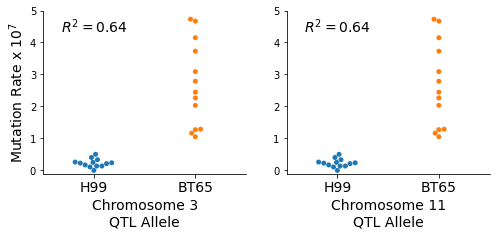

In [27]:
## plot phenotypes by genotypes for 
## Chromosome 3
fig,ax = plt.subplots(1,2,figsize=(8,3))
plt.sca(ax[0])
sns.swarmplot(x='CH3',y='Rate',data=to_use_data);
plt.xlabel('Chromosome 3\nQTL Allele',fontsize=14);
plt.ylabel('Mutation Rate x 10$^7$',fontsize=14)
plt.xticks([0,1],['H99','BT65'],fontsize=14);
plt.ylim(-0.1,5)
[ax[0].spines[s].set_visible(False) for s in ['top','right']]
plt.text(0,4.5,'$R^2 = %s$'%ch3_rs,fontsize=14,va='center',ha='center')

## And chromosome 11
plt.sca(ax[1])
plt.text(0,4.5,'$R^2 = %s$'%ch11_rs,fontsize=14,va='center',ha='center')
sns.swarmplot(x='CH11',y='Rate',data=to_use_data);
plt.ylim(-0.1,5)
plt.ylabel('');plt.xlabel('Chromosome 11\nQTL Allele',fontsize=14);
plt.xticks([0,1],['H99','BT65'],fontsize=14);
[ax[1].spines[s].set_visible(False) for s in ['top','right']];

In [28]:
## Gather chormosome 3 and 11 SNPs
CH3 = SNP[(SNP.Contig=='Chr_3')]
CH11 = SNP[(SNP.Contig=='Chr_11')]

In [29]:
## Conduct boot strapping on chrom 3
## To calculate CI
## Set savepath
ch3_95_savepath = '../DATA/H99_chr3.csv.gz'

## If it dosn't exist, run boot strapping
if not os.path.exists(ch3_95_savepath):
    
    ## CAlcualte 95 CI and save
    ch3l, ch3r = hqtl.qtl_boot(segs_to_use,CH3,to_use_data,'Rate')
    pd.DataFrame([ch3l,ch3r],columns=['Chr_3']).to_csv(ch3_95_savepath)

else:
    
    ## Load dataframe
    ch3_95df = pd.read_csv(ch3_95_savepath,index_col=0)
    ch3l,ch3r = ch3_95df.T.values[0]

## print bounds
ch3l,ch3r

(918548.4125, 1120200.5)

In [30]:
## Conduct boot strapping on chrom 11
## To calculate CI
## Set savepath
ch11_95_savepath = '../DATA/H99_chr11.csv.gz'

## if it dosn't exist, run boot strapping
if not os.path.exists(ch11_95_savepath):
    
    ## Calculte 95 CI and save
    ch11l, ch11r = hqtl.qtl_boot(segs_to_use,CH11,to_use_data,'Rate')
    pd.DataFrame([ch11l,ch11r],columns=['Chr_11']).to_csv(ch11_95_savepath)

else:
    
    ## Load dataframe
    ch11_95df = pd.read_csv(ch11_95_savepath,index_col=0)
    ch11l,ch11r = ch11_95df.T.values[0]
    
## print bounds
ch11l,ch11r

(987379.1125, 1193972.0)

In [31]:
colorblind = ['#E69F00','#009E73','#CC79A7',
              '#56B4E9','#0072B2','#D55E00','#0072B2']

In [32]:
## Load in grid spec
from matplotlib.gridspec import GridSpec

In [33]:
new_to_plot = data.loc[samples].sort_values("Rate").copy()

In [34]:
new_to_plot.Lci.max()

6.4589

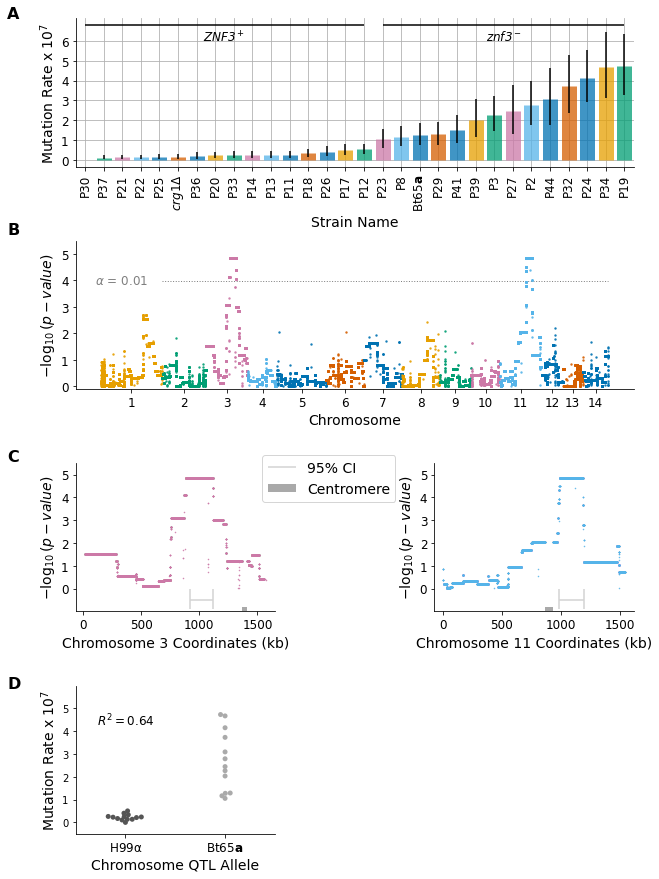

In [35]:
## Call figure and set up grid spec
fig = plt.figure(figsize=(10,15))
gs = GridSpec(4,5,figure=fig)

## set kb conversion
kb = 1000

## Add sub axis
## for phenotypes
phenoax = fig.add_subplot(gs[0,:])

## manhattan plot
qtlax = fig.add_subplot(gs[1,:])

## QTL on chromosomes 3 and 11
ch3ax = fig.add_subplot(gs[2,0:2])
ch11ax = fig.add_subplot(gs[2,3:5])

## Phenotype axis per chromosome
ch3pax = fig.add_subplot(gs[3,0:2])
#ch11pax = fig.add_subplot(gs[3,3:5])

## ---------------------------------------------------------------------------------------- ##

## Set axis for phenotype data
plt.sca(phenoax)

## Remove spines
[phenoax.spines[s].set_visible(False) 
 for s in ['top','right']]

## Set x position 
xpos = np.arange(new_to_plot.shape[0])

## plot phenotype and CI
#plt.plot(xpos,to_plot.Rate,'r.',label='Mean');
[plt.vlines(xpos[i],0,r,alpha=0.75,
            color=colorblind[i%len(colorblind)],
            linewidth=15) 
 for i,r in enumerate(new_to_plot.Rate.values)]

plt.grid(True)
plt.vlines(xpos,new_to_plot.Lci,new_to_plot.Uci,color='k')


plt.hlines(6.8,0,15,color='k')
plt.text(x=15/2,y=6.6,
         s='ZNF3$^+$',fontstyle='italic',
         va='top',ha='center',
         fontsize=12)

plt.hlines(6.8,16,new_to_plot.shape[0]-1,color='k')
plt.text(x=(new_to_plot.shape[0]-1+16)/2,y=6.6,
         s = 'znf3$^-$',fontstyle='italic',
         fontsize=12,va='top',ha='center')

## Relable x-axis
label_plot = []
italic_xs = []

## Iterate thru samples
for i,s in enumerate(new_to_plot.index.tolist()):
    
    ## Progeny genotypes
    if s not in ['crg1','Bt65']:
        label_plot.append('P%s'%s)
    
    ## H99 parnets
    elif s == 'crg1':
        label_plot.append('$\it{crg1}$'+r'$\mathit{\Delta}$')
        italic_xs.append(i)
        
    ## Bt65 label
    elif s == 'Bt65':
        label_plot.append(bt_label)
        #italic_xs.append(i)
        
## Set xticks and xlabel
plt.xticks(xpos,label_plot,rotation=90,fontsize=12)
#[phenoax.get_xticklabels()[ix].set_style("italic") for ix in italic_xs]
plt.xlabel('Strain Name',fontsize=14)

## Add y-labels and yticks
plt.ylabel('Mutation Rate x 10$^7$',fontsize=14);
plt.yticks(np.arange(0,7),fontsize=12)

plt.xlim(-0.5,new_to_plot.shape[0]-0.5)

## ----------------------------------------------------------------------------------------- ##

## Set manhattan axis and remove axis
plt.sca(qtlax)
[qtlax.spines[s].set_visible(False) for s in ['top','right']];

## Iterate thru chromosomes
for i,c in clens.iterrows():
    
    ## slice datframes
    cumsum = c['Cumsum']
    temp = pvaldf[(pvaldf.Contig==c.Contig)]
    
    ## plot QTL
    plt.plot(temp.Pos+cumsum,temp.Pval,
             '.',alpha=0.75,
             markersize=3,rasterized=True,
             color=colorblind[i%len(colorblind)]);

## Set ylabel, limit, and y-ticks
plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=14);
plt.ylim(-0.1,5.5)
plt.yticks(np.arange(6),fontsize=12)

## Set xticks and xlables
plt.xticks(clens.Midpts.values,clens.index.values+1,
           fontsize=12);
plt.xlabel('Chromosome',fontsize=14);

## Plot QTL threshold
plt.hlines(thres_99,clens.Length.tolist()[0],
           posmax,linestyle=':',
           linewidth=1,color='k',alpha=0.5)

## Add label to threshold
plt.text(clens.Midpts.tolist()[0]*(2/3),thres_99,
         s = r'$\alpha$ = 0.01',color='k',alpha=0.5,
         va='center',ha='center',fontsize=12)

## ----------------------------------------------------------------------------------------- ##

## Set chromosome QTL 3 axis and remove spines
plt.sca(ch3ax)
[ch3ax.spines[s].set_visible(False) for s in ['top','right']];

## Gather temp chromosome dataframe sort by position
temp = pvaldf[(pvaldf.Contig=='Chr_3')].copy()
temp.sort_values('Pos',inplace=True)

## plot QTL
plt.plot(temp.Pos/kb,temp.Pval,'.',
         color = colorblind[2%len(colorblind)],
         markersize=1);

## plot CI
plt.hlines(-0.5,ch3l/kb,ch3r/kb,color='lightgrey');
plt.vlines(np.array([ch3l/kb,ch3r/kb]),-.9,0,
           label='95% CI',color='lightgrey')

## Set ytikcs, xlable, ylimit, and ylabels
plt.yticks(np.arange(6),fontsize=12);
plt.xticks(fontsize=12)
plt.xlabel('Chromosome 3 Coordinates (kb)',fontsize=14)
plt.ylim(-1,5.5)
plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=14);

## Add centromere
plt.hlines(-1,*Centromeres.T[2].values/kb,
           color='darkgrey',label='Centromere',linewidth=8)

## Add legend
lgnd = plt.legend(bbox_to_anchor=(.9,1.1),fontsize=14)
#lgnd.legendHandles[0]._legmarker.set_markersize(10)
#lgnd.legendHandles[2].set_markersize(1)

## ------------------------------------------------------------------------------------------- ##

## Set chromosome QTL 11 axis and remove spines
plt.sca(ch11ax)
[ch11ax.spines[s].set_visible(False) for s in ['top','right']];

## Slice dataframe sort by pos
temp = pvaldf[(pvaldf.Contig=='Chr_11')].copy()
temp.sort_values('Pos',inplace=True)

## plot QTL
plt.plot(temp.Pos/kb,temp.Pval,'.',
         color=colorblind[10%len(colorblind)],
         markersize=1);

## Add CI
plt.hlines(-0.5,ch11l/kb,ch11r/kb,color='lightgrey');
plt.vlines(np.array([ch11l/kb,ch11r/kb]),-.9,0,color='lightgrey')

## Set yticks, xlabel, ylim, ylabel
plt.yticks(np.arange(6),fontsize=12);
plt.xlabel('Chromosome 11 Coordinates (kb)',fontsize=14);
plt.ylim(-1,5.5)
plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=14);
plt.xticks(fontsize=12)

## plot centromere
plt.hlines(-1,*Centromeres.T[10].values/kb,
           color='darkgrey',label='Centromere',linewidth=8)

## ------------------------------------------------------------------------------------------ ##

## set axis for chromosome 3 phenotype data and 
## remove spines
plt.sca(ch3pax)
[ch3pax.spines[s].set_visible(False) for s in ['top','right']];

## Plot swamplot for chromosome 3 genotype x phenotype
sns.swarmplot(x='CH3',y='Rate',data=to_use_data,palette='gray');

## Set xlabel and xticks
plt.xlabel('Chromosome QTL Allele',fontsize=14);
plt.xticks([0,1],[h99_label,bt_label],fontsize=12);

## Set ylimits, ylabel, and yticks
plt.ylim(-0.5,6)
plt.ylabel('Mutation Rate x 10$^7$',fontsize=14)
plt.yticks(np.arange(6))

#[ch3pax.spines[s].set_visible(False) for s in ['top','right']]
## annotate R2
plt.text(0,4.5,'$R^2 = %s$'%ch3_rs,fontsize=12,va='center',ha='center')

## ----------------------------------------------------- ##

## Adjust suplots
plt.subplots_adjust(hspace=0.5,wspace=0.5);

## Add figure section lables
lx = 0.03
fig.text(lx,0.88,'A',fontweight='bold',fontsize=16)
fig.text(lx,0.68,'B',fontweight='bold',fontsize=16)
fig.text(lx,0.47,'C',fontweight='bold',fontsize=16)
fig.text(lx,0.26,'D',fontweight='bold',fontsize=16);

## Set save path
#savepath = '../FIGURES/Figure_4_Hypermutator_Phenotypes_and_QTL.pdf'

## Save figure
#plt.savefig(savepath,dpi=300,bbox_inches='tight');

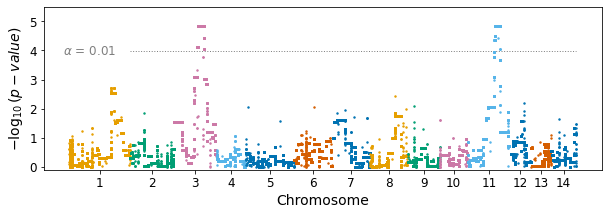

In [36]:
fig,ax = plt.subplots(1,1,figsize=(10,3))
## Iterate thru chromosomes
for i,c in clens.iterrows():
    
    ## slice datframes
    cumsum = c['Cumsum']
    temp = pvaldf[(pvaldf.Contig==c.Contig)]
    
    ## plot QTL
    plt.plot(temp.Pos+cumsum,temp.Pval,
             '.',alpha=0.9,
             markersize=3,rasterized=True,
             color=colorblind[i%len(colorblind)]);

## Set ylabel, limit, and y-ticks
plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=14);
plt.ylim(-0.1,5.5)
plt.yticks(np.arange(6),fontsize=12)

## Set xticks and xlables
plt.xticks(clens.Midpts.values,clens.index.values+1,
           fontsize=12);
plt.xlabel('Chromosome',fontsize=14);

## Plot QTL threshold
plt.hlines(thres_99,clens.Length.tolist()[0],
           posmax,linestyle=':',
           linewidth=1,color='k',alpha=0.5)

## Add label to threshold
plt.text(clens.Midpts.tolist()[0]*(2/3),thres_99,
         s = r'$\alpha$ = 0.01',color='k',alpha=0.5,
         va='center',ha='center',fontsize=12);

## save as a pdf
plt.savefig('../FIGURES/Hypermutator_Manhattan_plot.pdf',
           dpi=300,bbox_inches='tight');

In [37]:
pvaldf.to_csv('./Bt65_prog_QTL_info.csv')

In [38]:
## Gather chromosome 3 QTL
chr3 = pvaldf[(pvaldf.Contig=='Chr_3') & 
              (pvaldf.Pos>=0.8*10**6) & 
              (pvaldf.Pos<=1.2*10**6) & 
              (pvaldf.Pval>3)]

## Set pval max
pval_max = chr3.Pval.max()

## Set QTL ylimit
maxy = np.round(pval_max+1)

## Get QTL left and right
qtlleft = chr3[(chr3.Pval==pval_max)].Pos.min()
qtlrigh = chr3[(chr3.Pval==pval_max)].Pos.max()

In [39]:
## Bring in gff file
gffpath = '/home/croth/Hypermutator/FungiDB-43_CneoformansH99.gff'

gff = pd.read_csv(gffpath,sep='\t',comment='#',
                  names=['Contig','Source','Type','Start','End',
                         'Score','Strand','Phase','Description'])
chr3_name = sorted(gff.Contig.unique())[2]

gff3 = gff[(gff.Contig==chr3_name) &  
            (gff.Start>=qtlleft) & 
              (gff.End<=qtlrigh)]

gff3.head()

,Contig,Source,Type,Start,End,Score,Strand,Phase,Description
634,CP003822.1,EuPathDB,gene,1104486,1105762,.,-,.,ID=CNAG_12298;description=unspecified product
635,CP003822.1,EuPathDB,ncRNA,1104486,1105762,.,-,.,ID=CNAG_12298-t26_1;Parent=CNAG_12298;descript...
636,CP003822.1,EuPathDB,exon,1104486,1105296,.,-,.,ID=exon_CNAG_12298-E2;Parent=CNAG_12298-t26_1
637,CP003822.1,EuPathDB,exon,1105353,1105762,.,-,.,ID=exon_CNAG_12298-E1;Parent=CNAG_12298-t26_1
1078,CP003822.1,EuPathDB,gene,1012931,1013442,.,+,.,ID=CNAG_12288;description=unspecified product


In [40]:
genes = gff3[(gff3.Type=='gene')].sort_values('Start').copy()

xp = np.linspace(0,np.pi,len(genes))

genes['Y'] = np.sin(xp)*3

In [41]:
## set kb conversion
kb = 1000

In [42]:
#import  sys
#sys.path.insert(0, '/home/croth/QTL-functions/SCRIPTS/')
#import snpy
#snpspath = glob.glob('../GENOTYPE/GENES/P19/*.csv.gz')
#snpres = snpy.snpresults(snpspath)

In [43]:
snpres = pd.read_csv('../GENOTYPE/GENES/SNP_results.csv')
snpres.head()

,Strain,Gene,Parent,Expected,Ref,Alt,Refstop,Altstop,Nonsyn,Nvars,Utr5,Utr3,Exon,Intron,Lengthdif,Strand,Start,End,Seqid,Description
0,19,CNAG_01815,CNAG_01815-t26_1,990.0,990,990,1,1,16,37,0,2,33,2,0.0,-1,989854,993351,CP003830.1,hypothetical protein
1,19,CNAG_01816,CNAG_01816-t26_1,283.0,283,283,1,1,20,60,1,25,30,4,0.0,1,993455,996304,CP003830.1,hypothetical protein hypothetical protein variant
2,19,CNAG_01816,CNAG_01816-t26_2,283.0,283,283,1,1,20,60,1,23,30,6,0.0,1,993455,996304,CP003830.1,hypothetical protein hypothetical protein variant
3,19,CNAG_01817,CNAG_01817-t26_1,674.0,674,674,1,1,12,50,5,12,29,4,0.0,-1,994134,996999,CP003830.1,signal recognition particle receptor subunit a...
4,19,CNAG_01818,CNAG_01818-t26_1,292.0,292,292,1,1,4,36,0,17,15,4,0.0,1,997140,999627,CP003830.1,ATP synthase mitochondrial F1 complex assembly...


In [44]:
snpres[(snpres.Ref!=snpres.Expected)]

,Strain,Gene,Parent,Expected,Ref,Alt,Refstop,Altstop,Nonsyn,Nvars,Utr5,Utr3,Exon,Intron,Lengthdif,Strand,Start,End,Seqid,Description


In [45]:
snpres[(snpres.Gene=='CNAG_02700')]

,Strain,Gene,Parent,Expected,Ref,Alt,Refstop,Altstop,Nonsyn,Nvars,Utr5,Utr3,Exon,Intron,Lengthdif,Strand,Start,End,Seqid,Description
127,19,CNAG_02700,CNAG_02700-t26_1,1561.0,1561,95,1,2,22,62,3,3,53,3,0.939142,-1,970996,976412,CP003822.1,C2H2 type zinc finger transcription factor
128,19,CNAG_02700,CNAG_02700-t26_2,1562.0,1562,95,1,2,22,62,3,3,53,3,0.939181,-1,970996,976412,CP003822.1,C2H2 type zinc finger transcription factor


In [46]:
snpres.groupby('Altstop').count().T.head().T

,Strain,Gene,Parent,Expected,Ref
Altstop,,,,,
0,1,1,1,1,1
1,166,166,166,166,166
2,6,6,6,6,6
8,1,1,1,1,1


In [47]:
nonsense_gens = snpres[(snpres.Altstop!=1)].Gene.unique()

In [48]:
1-(nonsense_gens.shape[0]/snpres.Gene.unique().shape[0])

0.9556962025316456

In [49]:
snpres[(snpres.Gene.isin(nonsense_gens))]

,Strain,Gene,Parent,Expected,Ref,Alt,Refstop,Altstop,Nonsyn,Nvars,Utr5,Utr3,Exon,Intron,Lengthdif,Strand,Start,End,Seqid,Description
26,19,CNAG_01836,CNAG_01836-t26_1,521.0,521,503,1,2,18,31,0,0,23,8,0.034549,1,1042367,1044262,CP003830.1,long-chain acyl-CoA synthetase
72,19,CNAG_01883,CNAG_01883-t26_1,322.0,322,144,1,2,14,43,0,0,20,23,0.552795,-1,1171247,1173092,CP003830.1,hypothetical protein
127,19,CNAG_02700,CNAG_02700-t26_1,1561.0,1561,95,1,2,22,62,3,3,53,3,0.939142,-1,970996,976412,CP003822.1,C2H2 type zinc finger transcription factor
128,19,CNAG_02700,CNAG_02700-t26_2,1562.0,1562,95,1,2,22,62,3,3,53,3,0.939181,-1,970996,976412,CP003822.1,C2H2 type zinc finger transcription factor
166,19,CNAG_07528,CNAG_07528-t26_1,463.0,463,404,1,2,69,26,0,1,23,2,0.127430,-1,1070491,1072131,CP003822.1,hypothetical protein
170,19,CNAG_07610,CNAG_07610-t26_1,108.0,108,109,1,0,4,8,0,3,3,2,0.009259,1,1119077,1119717,CP003830.1,hypothetical protein
171,19,CNAG_07611,CNAG_07611-t26_1,67.0,67,40,1,2,6,6,0,0,3,3,0.402985,-1,1170371,1170866,CP003830.1,hypothetical protein
173,19,CNAG_07969,CNAG_07969-t26_1,309.0,309,34,1,8,67,25,0,0,22,3,0.889968,1,930460,931520,CP003822.1,hypothetical protein


In [50]:
snpres.Refstop.unique()

array([1])

In [51]:
gene_jitter = np.abs(np.random.normal(0,0.05,snpres.shape[0]))

In [52]:
hypos = ['hypothetical protein',
         'hypothetical protein hypothetical protein variant',
         'hypothetical protein hypothetical protein variant 1 hypothetical protein variant 2']

NameError: name 'to_plot' is not defined

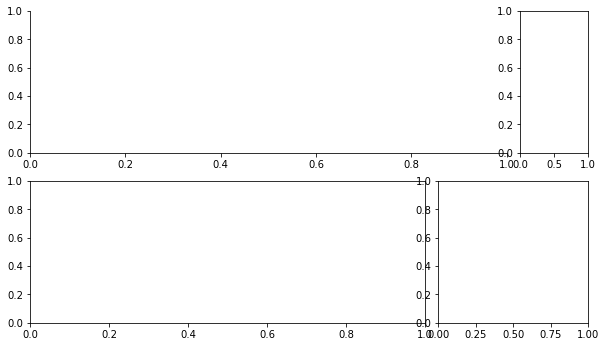

In [53]:
## Call figure and set up grid spec
fig = plt.figure(figsize=(10,12))
fig.set_facecolor('w')

## Add grid spec
gs = GridSpec(4,7,figure=fig)

## Add sub axis for phenotypes
phenoax = fig.add_subplot(gs[0,:-1])
histax = fig.add_subplot(gs[0,-1])

## manhattan plot
qtlax = fig.add_subplot(gs[1,:-2])

## Phenotype axis per chromosome
ch3pax = fig.add_subplot(gs[1,-2:])

## ---------------------------------------------------------------------------------------- ##

## Set axis for phenotype data
plt.sca(phenoax)

## Remove spines
[phenoax.spines[s].set_visible(False) for s in ['top','right']]

## Set x position 
xpos = np.arange(to_plot.shape[0])

## plot phenotype and CI
plt.plot(xpos,to_plot.Rate,'.',
         color='tab:grey',label='Mean');
plt.vlines(xpos,to_plot.Lci,to_plot.Uci,
           'tab:grey',alpha=0.2,label='95% CI')

## Add legend
plt.legend(loc=0)

## Set ylimits, ylabel, and yticks
plt.ylim(-0.5,6)
plt.yticks(np.arange(7))
plt.ylabel('Mutation Rate x 10$^7$',fontsize=12)

## Relable x-axis
label_plot = []
label_pos = []

## Iterate thru samples
for i,s in enumerate(to_plot.index.tolist()):
    
    ## Progeny genotypes
    if s not in ['crg1','Bt65']:
        label_plot.append('P%s'%s)
        label_pos.append(i)
    
    ## H99 parnets
    elif s == 'crg1':
        label_plot.append(h99_label)
        
    ## Bt65 label
    elif s == 'Bt65':
        label_plot.append(bt_label)
        
## Set xticks and xlabel
plt.xticks(xpos,label_plot,rotation=90)
plt.xlabel('Strain Name',fontsize=12)

## ------------------------------------------------------------------------------------- ##

## Plot histogram
plt.sca(histax)
plt.hist(to_plot.Rate.values,color='tab:grey',
         alpha=0.25,orientation='horizontal',
         bins = np.arange(7)-0.5)

## Turn off axis
[histax.spines[s].set_visible(False) for s in ['top','right']];

## Set ylimits, yticks, and ylabel
plt.ylim(-0.5,6)
plt.yticks(np.arange(7))
plt.ylabel('Mutation Rate x 10$^7$',fontsize=12)

## Set xticks and xlables
plt.xticks([0,6,12])
plt.xlabel('Number of\nStrains',fontsize=12)

## ----------------------------------------------------------------------------------------- ##

## Set manhattan axis and remove axis
plt.sca(qtlax)
[qtlax.spines[s].set_visible(False) for s in ['top','right']];

## Iterate thru chromosomes
for i,c in clens.iterrows():
    
    ## slice datframes
    cumsum = c['Cumsum']
    temp = pvaldf[(pvaldf.Contig==c.Contig)]
    
    ## plot QTL
    plt.plot(temp.Pos+cumsum,temp.Pval,
             '.',alpha=0.5,
             markersize=3, 
             rasterized = True,
             color='k' if c.Chrom in ['3','11'] else chrom_colors[(i+1)%len(chrom_colors)]);

## Set ylabel, limit, and y-ticks
plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=12);
plt.ylim(-0.1,maxy)
plt.yticks(np.arange(maxy+1))

## Set xticks and xlables
plt.xticks(clens.Midpts.values,clens.Chrom.values);
plt.xlabel('Chromosome',fontsize=12);

## Plot QTL threshold
plt.hlines(thres_99,clens.Length.tolist()[0],
           posmax,linestyle=':',linewidth=1,color='tab:grey',alpha=0.8)

## Add label to threshold
plt.text(clens.Midpts.tolist()[0]*(2/3),thres_99,
         s = r'$\alpha$ = 0.01',color='tab:Grey',alpha=0.8,
         va='center',ha='center',fontsize=12)

## ------------------------------------------------------------------------------------------ ##

## set axis for chromosome 3 phenotype data and 
## remove spines
plt.sca(ch3pax)
[ch3pax.spines[s].set_visible(False) for s in ['top','right']];

## Plot swamplot for chromosome 3 genotype x phenotype
sns.swarmplot(x='CH3',y='Rate',data=to_use_data,palette='gray',size=4);

## Set xlabel and xticks
plt.xlabel('QTL Allele',fontsize=12);
plt.xticks([0,1],[h99_label,bt_label],fontsize=12);

## Set ylimits, ylabel, and yticks
plt.ylim(-0.5,6)
plt.yticks(np.arange(7))
plt.ylabel('Mutation Rate x 10$^7$',fontsize=12)

## annotate R2
plt.text(0.1,5.5,'$R^2 = %s$'%ch3_rs,fontsize=12,va='center',ha='center',color='tab:grey')
## ------------------------------------------------------------------------------------------ ##

## MAke and set figure axes
chromax = fig.add_axes([0.125,0.37,0.78,0.1])
#plt.sca(chromax)

## Turn off axis
plt.axis('off')

ch3p = pvaldf[(pvaldf.Contig=='Chr_3')].Pos
plt.plot(ch3p, np.ones(len(ch3p)),'ko',rasterized=True,markersize=4)
plt.title('Chromosome 3', x=0.1)

plt.text(np.mean([qtlleft,qtlrigh]),45,'QTL 95% CI',va='center',ha='center',fontsize=10,color='grey')
plt.hlines(25,qtlleft,qtlrigh,color='tab:grey',linestyle='--')
plt.vlines(np.array([qtlleft,qtlrigh]),0,47,color='tab:grey')

plt.hlines(-25,np.min(ch3p),250000+np.min(ch3p),color='tab:grey')
plt.text((250000+np.min(ch3p))/2,-45,s='250 kb',fontsize=10,color='tab:grey',va='center',ha='center')

plt.vlines(np.array([qtlleft,qtlrigh]),0,-25,linestyle='-',color='tab:grey')
plt.plot(np.array([0,qtlleft]),[-150,-25],color='tab:grey')
plt.plot(np.array([qtlrigh,np.max(ch3p)]),[-25,-150],color='tab:grey')

plt.ylim(-150,50)
plt.xlim(0,np.max(ch3p))

## ------------------------------------------------------------------------------------------ ##

geneax = fig.add_axes([0.125,0.12,0.78,0.25])
plt.sca(geneax)

plt.ylabel('% Difference in Protein Length',
           fontsize=12,y=0.6)
plt.xlabel('Chromosome 3 Coordinates (kb)',fontsize=12)

plt.ylim(-0.25,1)
plt.xlim(qtlleft,qtlrigh)
plt.yticks(np.arange(0,1.25,0.25),labels=[int(a) for a in np.arange(0,1.25,0.25)*100])

for i,g in snpres[(snpres.Seqid==chr3_name)].iterrows():
    
    gc = 'tab:grey' if g.Description in hypos else 'k'
    alpha = 0.5 if g.Description in hypos else 0.9
    gy = g.Lengthdif - (0 if g.Lengthdif > 0.1 else gene_jitter[i])
    
    plt.hlines(gy,g.Start,g.End,
               color=gc,linewidth=3,alpha=alpha)
    
    pos = g.End if g.Strand > 0 else g.Start
    mr = '>' if g.Strand > 0 else '<'
    plt.plot(pos,gy,marker=mr,
             color=gc,alpha=alpha)
    
    if gy>.2:
        
        gname = g.Gene
        if gname == 'CNAG_02700':
            gname = 'ZNF3'
        elif gname == 'CNAG_02680':
            gname = 'VPS15'
        else:
            gname = g.Gene
            
        plt.text(pos,gy-0.05,s=gname,
                 va='top',ha='center',fontstyle='italic')

geneax.spines['top'].set_visible(False)

p,l = plt.xticks()

plt.xticks(p[1:-1],[int(x/1000) for x in p[1:-1]])

plt.plot(900000,0.5,'s',color='k',label='Known Gene')
plt.plot(900000,0.5,'s',color='tab:grey',alpha=0.5,
         label='Hypothetical Gene')
plt.plot(900000,0.5,'s',color='w',ms=10)
plt.legend()

## ------------------------------------------------------------------------------------------- ##

## Adjust suplots
plt.subplots_adjust(hspace=0.9,wspace=2);

## Add figure section lables
fig.text(0.065,0.9,'A',fontweight='bold',fontsize=14)
fig.text(0.795,0.9,'B',fontweight='bold',fontsize=14)
fig.text(0.065,0.68,'C',fontweight='bold',fontsize=14)
fig.text(0.67,0.68,'D',fontweight='bold',fontsize=14)
fig.text(0.065,0.48,'E',fontweight='bold',fontsize=14);

## Set save path
savepath = '../FIGURES/Figure_4_Hypermutator_Phenotypes_and_QTL.pdf'

## Save figure
#plt.savefig(savepath,dpi=400,bbox_inches='tight');

In [ ]:
tempsnpres = pd.concat([g.sort_values('Lengthdif').tail(1) for i,g in snpres.groupby('Gene')])

In [ ]:
sampels_to_plt = ['19','34','24','21','37','30']

In [ ]:
## Call figure and set up grid spec
fig = plt.figure(figsize=(10,7))
fig.set_facecolor('w')

## Add grid spec
gs = GridSpec(6,2,figure=fig)

chry = -0.1
kblen = 250000
textymod = 10

for i,ch in enumerate(['Chr_3','Chr_11']):
    
    ## Set axis and gather contig info
    qtlax = fig.add_subplot(gs[:4,i])
    chpval = pvaldf[(pvaldf.Contig==ch)]
    
    ## Set title
    plt.title('Chromosome %s'%ch.split('_')[-1],fontsize=12)
    
    ## Plot pvalues
    plt.plot(chpval.Pos,chpval['Pval'].values,'.',
             color = colorblind[1],markersize=1,rasterized=True)
    
    ## Set pval max
    pval_max = chpval.Pval.max()

    ## Get QTL left and right
    qtlleft = chpval[(chpval.Pval==pval_max)].Pos.min()
    qtlrigh = chpval[(chpval.Pval==pval_max)].Pos.max()
    
    ## Annotate and mare CI
    plt.text(np.mean([qtlleft,qtlrigh]),0.45,'QTL 95% CI',
             va='center',ha='center',fontsize=10,color='grey')
    plt.hlines(0.1,qtlleft,qtlrigh,color='tab:grey',linestyle='--')
    plt.vlines(np.array([qtlleft,qtlrigh]),chry*2,0.3,color='tab:grey')

    plt.hlines(-0.25,chpval.Pos.min(),kblen+chpval.Pos.min(),color='tab:grey',linewidth=2)
    plt.text((kblen+chpval.Pos.min())/2,-0.5,s='250 kb',
             fontsize=10,color='k',va='center',ha='center')
    
    ## Adjust x and y axis
    plt.xticks([],[])
    plt.ylim(-1,5.25)
    plt.xlim(0,chpval.Pos.max())
    plt.yticks(np.arange(6),np.array(np.arange(6),dtype=int) if i == 0 else [],fontsize=10)
    fig.text(0.07,0.67,'$-\log_{10}\,(p-value)$',
             fontsize=12,rotation=90,va='center',ha='center')
    
    ## Add spines
    plt.vlines((0,chpval.Pos.max()),1.5*chry,5.25,linewidth=2,color='k')
    plt.hlines(5.25,0,chpval.Pos.max(),linewidth=2,color='k')

    ## Turn off spines
    [qtlax.spines[s].set_visible(False) for s in ['bottom','left','right','top']]
    
    ## Plot zoom lines
    plt.plot(np.array([0,qtlleft]),[-1,chry*2],color='tab:grey')
    plt.plot(np.array([qtlrigh,chpval.Pos.max()]),[chry*2,-1],color='tab:grey')

    ## Make chromosome model
    plt.plot(chpval.Pos, chry*np.ones(len(chpval.Pos)),'ko',rasterized=True,markersize=2)
    
    #for si,s in enumerate(sampels_to_plt):
    #    for g in [0,1]:
    #        stemp = chpval[(chpval[s]==g)]
    #        
    #        plt.plot(stemp.Pos,(chry-(si*1.5))*np.ones(stemp.shape[0]),'.',
    #                 color='tab:blue' if g == 0 else 'tab:orange',
    #                 markersize=0.5)
        
    ## Input phenotype by genotype plot
    chpax = fig.add_axes([(0.18,0.59)[i],0.74,0.1,0.1])
    plt.sca(chpax)
    #[chpax.spines[s].set_visible(False) for s in ['top','right']];

    ## Plot swamplot for chromosome 3 genotype x phenotype
    sns.swarmplot(x='CH%s'%ch.split('_')[-1] ,y='Rate',
                  data=to_use_data,palette='gray',size=2);

    ## Set xlabel and xticks
    plt.xlabel('Chromosome %s\nQTL Allele'%ch.split('_')[-1],fontsize=8);
    plt.xticks([0,1],[h99_label,bt_label],fontsize=8);

    ## Set ylimits, ylabel, and yticks
    plt.ylim(-.5,6)
    plt.yticks(np.arange(7),fontsize=8)
    plt.ylabel('Mutation Rate x 10$^7$',fontsize=8)

    ## annotate R2
    plt.text(0.1,5.,'$R^2 = %s$'%ch3_rs,fontsize=8,
             va='center',ha='center',color='tab:grey')
    
    ## Make the zoom subplot    
    zoomax = fig.add_subplot(gs[4:,i])
    zoomax.spines['top'].set_visible(False)
    
    ## Plot genes and changes in predicted length
    for gi,g in tempsnpres[(tempsnpres.Seqid==snpres.Seqid.unique()[i])].iterrows():
    
        gc = 'tab:blue' if g.Strand>0 else 'tab:red'
        gy = g.Lengthdif - (0 if g.Lengthdif > 0.1 else gene_jitter[gi])
        plt.hlines(gy,g.Start,g.End,color=gc,linewidth=2.5,alpha=0.8)
        pos = g.End if g.Strand > 0 else g.Start

        gname = g.Gene
        if gname == 'CNAG_02700':
            gname = 'ZNF3'
            hal='left'
                
            plt.text(pos,gy+0.02,s=gname,va='bottom',
                     ha=hal,alpha = 0.6,
                     fontstyle='italic',fontsize=10,color='tab:grey')
                
        elif gname == 'CNAG_01836':
                plt.text(pos,0.16,s=gname,va='bottom',
                     ha='center', alpha = 0.6,
                     fontstyle='italic',fontsize=10,color='tab:grey')
                plt.vlines(np.mean([g.Start,g.End]),gy+0.01,0.15,
                           color='tab:grey',alpha=0.5,linewidth=0.5)
                
        elif gname == 'CNAG_07610':
                plt.text(pos,0.20,s=gname,va='bottom',
                     ha='center', alpha = 0.6,
                     fontstyle='italic',fontsize=10,color='tab:grey')
                plt.vlines(np.mean([g.Start,g.End]),gy+0.01,0.19,
                           color='tab:grey',alpha=0.5,linewidth=0.5)
            
        elif gy>.1:
                gname = g.Gene
                hal = 'center'if i == 0 else 'right'
            
                plt.text(pos,gy+0.02,s=gname,va='bottom',
                     ha=hal,alpha = 0.6,
                     fontstyle='italic',fontsize=10,color='tab:grey')
        else:
            pass
    
    ## Adjust y and x axis
    ## Set x and y limits
    plt.ylim(-.2,1)
    plt.xlim(qtlleft,qtlrigh)
    
    ## Set yaxis label and y- tick lables
    fig.text(0.07,0.25,'% Difference in\nProtein Length',
             fontsize=12,rotation=90,va='center',ha='center')
    plt.yticks(np.arange(0,1.25,0.25),
               np.array(np.arange(0,1.25,0.25)*100,dtype=int) if i == 0 else [],fontsize=10)
    
    ## Rename xticks
    p,l = plt.xticks()
    plt.xticks(p[1:-1],[int(x/1000) for x in p[1:-1]],fontsize=10)
    
    ## lable xlable
    plt.xlabel('Chromosome %s Coordinates (kb)'%ch.split('_')[-1],fontsize=12)
    
    #plt.vlines((chr3_tl,chr11_tl)[i],0,1)
    
plt.plot(1000000,0.5,'s',color='tab:red',label='Positively Oriented')
plt.plot(1000000,0.5,'s',color='tab:blue',label='Negatively Oriented')
plt.plot(1000000,0.5,'s',color='w',ms=10)
plt.legend(loc=2,fontsize=10)
plt.subplots_adjust(hspace=0,wspace=0.1)

plt.savefig('../FIGURES/Chromosome_3and11_QTL_zoomed.pdf',
            dpi=300,bbox_inches='tight');

In [ ]:
sampleys = np.linspace(-1.65,-0.5,len(sampels_to_plt))[::-1]
sampleys

In [ ]:
## Call figure and set up grid spec
fig = plt.figure(figsize=(10,7))
fig.set_facecolor('w')

## Add grid spec
gs = GridSpec(6,2,figure=fig)

chry = -0.1
kblen = 250000
textymod = 10

for i,ch in enumerate(['Chr_3','Chr_11']):
    
    ## Set axis and gather contig info
    qtlax = fig.add_subplot(gs[:4,i])
    chpval = pvaldf[(pvaldf.Contig==ch)]
    
    ## Set title
    plt.title('Chromosome %s QTL and Haplotypes'%ch.split('_')[-1],fontsize=12)
    
    ## Plot pvalues
    plt.plot(chpval.Pos,chpval['Pval'].values,'k.',
             markersize=1,rasterized=True)
    
    ## Set pval max
    pval_max = chpval.Pval.max()

    ## Get QTL left and right
    qtlleft = chpval[(chpval.Pval==pval_max)].Pos.min()
    qtlrigh = chpval[(chpval.Pval==pval_max)].Pos.max()
    
    ## Annotate and mark the CI
    plt.text(np.mean([qtlleft,qtlrigh]),0.1,'QTL 95% CI',
             va='center',ha='center',fontsize=10,color='grey')
    plt.hlines(-0.3,qtlleft,qtlrigh,color='tab:grey',linestyle='--')
    plt.vlines(np.array([qtlleft,qtlrigh]),-1.75,-0.1,color='tab:grey')

    ## Add scale bar
    plt.hlines(-.39,chpval.Pos.min(),kblen+chpval.Pos.min(),
               color='tab:grey',linewidth=2)
    plt.text((kblen+chpval.Pos.min())/2,-0.2,s='250 kb',
             fontsize=10,color='tab:grey',va='center',ha='center')
    
    ## Adjust x and y axis
    plt.xticks([],[])
    plt.ylim(-2.5,5.5)
    plt.xlim(0,chpval.Pos.max())
    plt.yticks(np.arange(6),np.array(np.arange(6),dtype=int) if i == 0 else [],fontsize=10)
    fig.text(0.05,0.7,'$-\log_{10}\,(p-value)$',
             fontsize=12,rotation=90,va='center',ha='center')
    
    ## Add spines
    plt.vlines(0,0,5.5,linewidth=1.5,color='k')
    #plt.vlines((0,chpval.Pos.max()),0,5.5,linewidth=1.5,color='k')
    #plt.hlines(5.5,0,chpval.Pos.max(),linewidth=1.5,color='k')

    ## Turn off spines
    [qtlax.spines[s].set_visible(False) for s in ['bottom','left','right','top']]
    
    ## Plot zoom lines
    plt.plot(np.array([0,qtlleft]),[-2.5,-1.75],color='tab:grey')
    plt.plot(np.array([qtlrigh,chpval.Pos.max()]),[-2.5,-1.75][::-1],color='tab:grey')
    plt.plot([ (380000,920000)[i], (chr3_tl,chr11_tl)[i] ], [-2.5,-1.9],
             color='tab:grey',linewidth=1,linestyle='--')

    for si,s in enumerate(sampels_to_plt):
        for g in [0,1]:
            stemp = chpval[(chpval[s]==g)]
            
            plt.plot(stemp.Pos, sampleys[si]*np.ones(stemp.shape[0]),'.',
                     color='tab:blue' if g == 0 else 'tab:orange',
                     markersize=0.5)
        plt.text(-50000,sampleys[si],'P%s'%s if i == 0 else None,
                 fontsize=7,va='center',ha='center')
            
    ## Plot translocation       
    plt.vlines((chr3_tl,chr11_tl)[i],-0.5,-1.9,color='tab:grey',linestyle='--',linewidth=1)
    
    
    ## Add haplotype labels
    fig.text(0.05,0.48,'Example F$_1$\nHaplotypes',fontsize=12,
            rotation=90,va='center',ha='center')
    
    ## Input phenotype by genotype plot
    chpax = fig.add_axes([(0.18,0.59)[i],0.74,0.1,0.1])
    plt.sca(chpax)

    ## Plot swamplot for chromosome 3 genotype x phenotype
    sns.swarmplot(x='CH%s'%ch.split('_')[-1] ,y='Rate',
                  data=to_use_data,size=2);

    ## Set xlabel and xticks
    plt.xlabel('Chromosome %s\nQTL Allele'%ch.split('_')[-1],fontsize=8);
    plt.xticks([0,1],[h99_label,bt_label],fontsize=8);

    ## Set ylimits, ylabel, and yticks
    plt.ylim(-.5,6)
    plt.yticks(np.arange(7),fontsize=8)
    plt.ylabel('Mutation Rate x 10$^7$',fontsize=8)

    ## annotate R2
    plt.text(0.1,5.,'$R^2 = %s$'%ch3_rs,fontsize=8,
             va='center',ha='center',color='tab:grey')
    
    ## Make the zoom subplot    
    zoomax = fig.add_subplot(gs[4:,i])
    zoomax.spines['top'].set_visible(False)
    
    ## Plot genes and changes in predicted length
    for gi,g in tempsnpres[(tempsnpres.Seqid==snpres.Seqid.unique()[i])].iterrows():
    
        gc = 'tab:blue' if g.Strand>0 else 'tab:red'
        gy = g.Lengthdif - (0 if g.Lengthdif > 0.1 else gene_jitter[gi])
        plt.hlines(gy,g.Start,g.End,color=gc,linewidth=2.5,alpha=0.8)
        pos = g.End if g.Strand > 0 else g.Start

        gname = g.Gene
        if gname == 'CNAG_02700':
            gname = 'ZNF3'
            hal='left'
                
            plt.text(pos,gy+0.02,s=gname,va='center',
                     ha='right',alpha = 0.6,
                     fontstyle='italic',fontsize=8,color='tab:grey')
                
        elif gname == 'CNAG_01836':
                plt.text(pos,0.16,s=gname,va='bottom',
                     ha='left', alpha = 0.6,
                     fontstyle='italic',fontsize=8,color='tab:grey')
                plt.vlines(np.mean([g.Start,g.End]),gy+0.01,0.15,
                           color='tab:grey',alpha=0.5,linewidth=0.5)
                
        elif gname == 'CNAG_07610':
                plt.text(pos,0.20,s=gname,va='bottom',
                     ha='left', alpha = 0.6,
                     fontstyle='italic',fontsize=8,color='tab:grey')
                plt.vlines(np.mean([g.Start,g.End]),gy+0.01,0.19,
                           color='tab:grey',alpha=0.5,linewidth=0.5)
            
        elif gy >.1:
                gname = g.Gene
                hal = 'right' if i == 0 else 'right'
            
                plt.text(pos,gy+0.02,s=gname,va='center',
                     ha=hal,alpha = 0.6,
                     fontstyle='italic',fontsize=8,color='tab:grey')
        else:
            pass
    
    ## Adjust y and x axis, set x and y limits
    plt.ylim(-.2,1)
    plt.xlim(qtlleft,qtlrigh)
    
    ## Set yaxis label and y- tick lables
    fig.text(0.05,0.25,'% Difference in\nProtein Length',
             fontsize=12,rotation=90,va='center',ha='center')
    plt.yticks(np.arange(0,1.25,0.25),
               np.array(np.arange(0,1.25,0.25)*100,dtype=int) if i == 0 else [],
               fontsize=10)
    
    ## Rename xticks
    p,l = plt.xticks()
    plt.xticks(p[1:-1],[int(x/1000) for x in p[1:-1]],fontsize=10)
    
    ## lable xlable
    plt.xlabel('Chromosome %s Coordinates (kb)'%ch.split('_')[-1],fontsize=12)
    
    ## Plot translocation site
    plt.vlines((chr3_tl,chr11_tl)[i],-0.5,1,color='k',alpha=0.75,
               linestyle='--',linewidth=0.5)
    plt.vlines((chr3_tl,chr11_tl)[i],0.18,0.81,color='w',linewidth=1)
    plt.text((chr3_tl,chr11_tl)[i],np.mean([0.3,0.7]),
             'Approx.\nTranslocation\nSite',rotation=90,
             va='center',ha='center',fontsize=10)

    if i == 0:
        plt.plot(1000000,0.5,'s',color='tab:red',label='Positive')
        plt.plot(1000000,0.5,'s',color='tab:blue',label='Negative')
        plt.plot(1000000,0.5,'s',color='w',ms=10)
        plt.legend(loc=1,fontsize=10,title='Gene Orientation')

plt.subplots_adjust(hspace=0,wspace=0.1)

plt.savefig('../FIGURES/Chromosome_3and11_QTL_zoomed.pdf',
            dpi=300,bbox_inches='tight');

In [ ]:
np.min((chry*si*1.5)*np.ones(stemp.shape[0])-0.5)


In [ ]:
    ## Set chromoome 3 and 11 translocations
chr3_tl = 938233 
chr11_tl = 1109626

In [ ]:
tempsnpres[(tempsnpres.Altstop!=1)].sort_values(['Seqid','Start'])

In [ ]:
fig,ax = plt.subplots(2,2,figsize=(10,7))

chry = -0.1
kblen = 250000
textymod = 10

for i,ch in enumerate(['Chr_3','Chr_11']):
    
    ## Set axis and gather contig info
    plt.sca(ax[0,i])
    chpval = pvaldf[(pvaldf.Contig==ch)]
    
    ## Set title
    plt.title('Chromosome %s'%ch.split('_')[-1],fontsize=12)
    
    ## Plot pvalues
    plt.plot(chpval.Pos,chpval['Pval'].values,'.',
             color = colorblind[1],markersize=1,rasterized=True)
    
    ## Set pval max
    pval_max = chpval.Pval.max()

    ## Get QTL left and right
    qtlleft = chpval[(chpval.Pval==pval_max)].Pos.min()
    qtlrigh = chpval[(chpval.Pval==pval_max)].Pos.max()
    
    ## Annotate and mare CI
    plt.text(np.mean([qtlleft,qtlrigh]),0.45,'QTL 95% CI',
             va='center',ha='center',fontsize=10,color='grey')
    plt.hlines(0.1,qtlleft,qtlrigh,color='tab:grey',linestyle='--')
    plt.vlines(np.array([qtlleft,qtlrigh]),chry*2,0.3,color='tab:grey')

    plt.hlines(-0.25,chpval.Pos.min(),kblen+chpval.Pos.min(),color='tab:grey')
    plt.text((kblen+chpval.Pos.min())/2,-0.5,s='250 kb',
             fontsize=10,color='tab:grey',va='center',ha='center')
    
    ## Adjust x and y axis
    plt.xticks([],[])
    plt.ylim(-1,5.25)
    plt.xlim(0,chpval.Pos.max())
    plt.yticks(np.arange(6),np.array(np.arange(6),dtype=int) if i == 0 else [],fontsize=10)
    fig.text(0.07,0.72,'$-\log_{10}\,(p-value)$',
             fontsize=12,rotation=90,va='center',ha='center')
    
    ## Add spines
    plt.vlines((0,chpval.Pos.max()),1.5*chry,5.25,linewidth=2,color='k')
    plt.hlines(5.25,0,chpval.Pos.max(),linewidth=2,color='k')
    
    ## Turn off spines
    [ax[0,i].spines[s].set_visible(False) for s in ['bottom','left','right','top']]
    ax[1,i].spines['top'].set_visible(False)
    
    ## Plot zoom lines
    plt.plot(np.array([0,qtlleft]),[-1,chry*2],color='tab:grey')
    plt.plot(np.array([qtlrigh,chpval.Pos.max()]),[chry*2,-1],color='tab:grey')

    ## Make chromosome model
    plt.plot(chpval.Pos, chry*np.ones(len(chpval.Pos)),'ko',rasterized=True,markersize=2)
    
    ## Plot genes and changes in predicted length
    plt.sca(ax[1,i])
    for gi,g in snpres[(snpres.Seqid==snpres.Seqid.unique()[i])].iterrows():
    
        gc = 'tab:blue' if g.Strand>0 else 'tab:red'
        gy = g.Lengthdif - (0 if g.Lengthdif > 0.1 else gene_jitter[gi])
    
        plt.hlines(gy,g.Start,g.End,color=gc,linewidth=3,alpha=0.8)
    
        pos = g.End if g.Strand > 0 else g.Start
        mr = '>' if g.Strand > 0 else '<'
        plt.plot(pos,gy,marker=mr,color=gc,alpha=alpha,markersize=2)
    
        if gy>.1:
        
            gname = g.Gene
            if gname == 'CNAG_02700':
                gname = 'ZNF3'
            
            else:
                gname = g.Gene
            
            plt.text(pos,gy-0.02,s=gname,va='top',
                     ha='center'if i == 0 else 'right',alpha = 0.6,
                     fontstyle='italic',fontsize=10,color='tab:grey')
    
    ## Adjust y and x axis
    ## Set x and y limits
    plt.ylim(-0.2,1)
    plt.xlim(qtlleft,qtlrigh)
    
    ## Set yaxis label and y- tick lables
    fig.text(0.07,0.35,'% Difference in Protein Length',
             fontsize=12,rotation=90,va='center',ha='center')
    plt.yticks(np.arange(0,1.25,0.25),
               np.array(np.arange(0,1.25,0.25)*100,dtype=int) if i == 0 else [],fontsize=10)
    
    ## Rename xticks
    p,l = plt.xticks()
    plt.xticks(p[1:-1],[int(x/1000) for x in p[1:-1]],fontsize=10)
    
    ## lable xlable
    plt.xlabel('Chromosome %s Coordinates (kb)'%ch.split('_')[-1],fontsize=12)
    
plt.subplots_adjust(hspace=0,wspace=0.1)

In [ ]:
snpres[(snpres.Gene=='CNAG_07528')]

In [ ]:
snpres[(snpres.Altstop!=1)]

In [ ]:
## Call figure and set up grid spec
fig = plt.figure(figsize=(10,5))
fig.set_facecolor('w')

## Add grid spec
gs = GridSpec(2,7,figure=fig)

## Add sub axis for phenotypes
phenoax = fig.add_subplot(gs[0,:])

## manhattan plot
qtlax = fig.add_subplot(gs[1,:-2])

## Phenotype axis per chromosome
ch3pax = fig.add_subplot(gs[1,-2:])

## ---------------------------------------------------------------------------------------- ##

## Set axis for phenotype data
plt.sca(phenoax)

## Remove spines
[phenoax.spines[s].set_visible(False) for s in ['top','right']]

## Set x position 
xpos = np.arange(to_plot.shape[0])

## plot phenotype and CI
plt.plot(xpos,to_plot.Rate,'.',color='tab:grey',label='Mean');
plt.vlines(xpos,to_plot.Lci,to_plot.Uci,
           'tab:grey',alpha=0.2,label='95% CI')

## Add legend
plt.legend(loc=0)

## Set ylimits, ylabel, and yticks
plt.ylim(-0.5,6)
plt.yticks(np.arange(7))
plt.ylabel('Mutation Rate x 10$^7$',fontsize=12)

## Relable x-axis
label_plot = []
label_pos = []

## Iterate thru samples
for i,s in enumerate(to_plot.index.tolist()):
    
    ## Progeny genotypes
    if s not in ['crg1','Bt65']:
        label_plot.append('P%s'%s)
        label_pos.append(i)
    
    ## H99 parnets
    elif s == 'crg1':
        label_plot.append(h99_label)
        
    ## Bt65 label
    elif s == 'Bt65':
        label_plot.append(bt_label)
        
## Set xticks and xlabel
plt.xticks(xpos,label_plot,rotation=90)
plt.xlabel('Strain Name',fontsize=12)

## ----------------------------------------------------------------------------------------- ##

## Set manhattan axis and remove axis
plt.sca(qtlax)
[qtlax.spines[s].set_visible(False) for s in ['top','right']];

## Iterate thru chromosomes
for i,c in clens.iterrows():
    
    ## slice datframes
    cumsum = c['Cumsum']
    temp = pvaldf[(pvaldf.Contig==c.Contig)]
    
    ## plot QTL
    plt.plot(temp.Pos+cumsum,temp.Pval,
             '.',alpha=0.5,
             markersize=3, 
             rasterized = True,
             color='k' if c.Chrom in ['3','11'] else chrom_colors[(i+1)%len(chrom_colors)]);

## Set ylabel, limit, and y-ticks
plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=12);
plt.ylim(-0.1,maxy)
plt.yticks(np.arange(maxy+1))

## Set xticks and xlables
plt.xticks(clens.Midpts.values,clens.Chrom.values);
plt.xlabel('Chromosome',fontsize=12);

## Plot QTL threshold
plt.hlines(thres_99,clens.Length.tolist()[0],
           posmax,linestyle=':',linewidth=1,color='tab:grey',alpha=0.8)

## Add label to threshold
plt.text(clens.Midpts.tolist()[0]*(2/3),thres_99,
         s = r'$\alpha$ = 0.01',color='tab:Grey',alpha=0.8,
         va='center',ha='center',fontsize=12)

## ------------------------------------------------------------------------------------------ ##

## set axis for chromosome 3 phenotype data and 
## remove spines
plt.sca(ch3pax)
[ch3pax.spines[s].set_visible(False) for s in ['top','right']];

## Plot swamplot for chromosome 3 genotype x phenotype
sns.swarmplot(x='CH3',y='Rate',
              data=to_use_data,
              size=4,color='tab:grey');

## Set xlabel and xticks
plt.xlabel('QTL Allele',fontsize=12);
plt.xticks([0,1],[h99_label,bt_label],fontsize=12);

## Set ylimits, ylabel, and yticks
plt.ylim(-0.5,6)
plt.yticks(np.arange(7))
plt.ylabel('Mutation Rate x 10$^7$',fontsize=12)

## annotate R2
plt.text(0.1,5.5,'$R^2 = %s$'%ch3_rs,fontsize=12,va='center',ha='center',color='tab:grey')
## ------------------------------------------------------------------------------------------ ##

## Adjust suplots
plt.subplots_adjust(hspace=0.9,wspace=2);

## Set save path
savepath = '../FIGURES/Figure_4_Hypermutator_Phenotypes_and_QTL.pdf'

## Save figure
#plt.savefig(savepath,dpi=400,bbox_inches='tight');

In [ ]:
g.Lengthdif

In [ ]:
olddf = pd.read_excel('./Supplementary_Tabel_S2.xlsx')

In [ ]:
olddf.Chromosome.unique()

In [ ]:
olddf[(olddf['Stop-loss'] == 'yes')]

In [ ]:
olddf[(olddf['Stop-gain'] == 'yes')]

In [ ]:
snpres[(snpres.Altstop!=1)]

In [ ]:
plt.hist(

In [ ]:
qtlrigh

In [ ]:
SNP['19']

In [ ]:
## Add 95% CI
plt.hlines(5.5,qtlleft,qtlrigh,color='tab:grey',linestyle='--')
plt.vlines(np.array([qtlleft,qtlrigh]),5.25,5.75,color='tab:grey')
plt.hlines(5.5,
           np.mean([qtlleft,qtlrigh])-20000,
           np.mean([qtlleft,qtlrigh])+20000,
           color='w',linewidth=5)

## annotate CI
plt.text(np.mean([qtlleft,qtlrigh]),5.5,s='95% CI',alpha=0.8,
         color='tab:grey',va='center',ha='center',fontsize=10)


In [ ]:
## Plot QTL for chromosome 3
plt.plot(chr3.Pos,chr3.Pval,'k.',alpha=0.5)

## Make a fake y-axis and set ylimits
plt.vlines(chr3.Pos.min()-(5*kb),3,maxy,color='k')
plt.ylim(-3,maxy+0.25)

## Turn off ylimit
plt.yticks([],[])

## Make new yticks
plt.hlines(np.arange(3,maxy+1),chr3.Pos.min()-(10*kb),
           chr3.Pos.min()-(5*kb),color='k')

## annotate yticks
[plt.text(chr3.Pos.min()-(15*kb),y,s='%s'%int(y),va='center',ha='center') 
 for y in np.arange(3,maxy+1)]

## Add ylabel
plt.text(x=chr3.Pos.min()-(25*kb),y=4.5,
         s='$-\log_{10}\,(p-value)$',fontsize=12,
         va='center',ha='center',rotation=90);

In [ ]:
## SAve pvalue dataframe
pvaldf.to_csv('../DATA/Bt65xH99_SNP_QTL.csv.gz')